<a href="https://colab.research.google.com/github/lebe1/text-oriented-data-science-project/blob/main/DOPP_Exercise2_Group55.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
!pip install stanza

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 24.8 MB/s eta 0:00:00


In [ ]:
!pip install wandb

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import pandas as pd
import json
import os
import random
import stanza
import nltk
from nltk.corpus import stopwords
import re
from tqdm import tqdm
import string
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import plotly.express as px
from transformers import pipeline
import ast
import plotly.graph_objects as go

import numpy as np
import time
from gensim.models import Word2Vec
from gensim.test.utils import common_texts

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report

import wandb


from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
from datasets import Dataset

from textblob import TextBlob

tqdm.pandas()

# Connect to Google Drive

In order for this to work, one has to make a copy of the shared Google Drive folder inside their own Google Drive. It can be accessed using this link:

https://drive.google.com/drive/folders/11GoNs2WUW2FajL45ZLaXGE_rlblHKlk2?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# change path if you want to access the files locally instead
folder_path = '/content/drive/MyDrive/DOPP_Ex2_data/'

# Data Loading and Preparation

**NOTE**: this section can be skipped if you have the combined_reviews.csv file already available

Which dataset(s) did you choose?  
Here, we downloaded four datasets from the [Amazon Reviews dataset](https://nijianmo.github.io/amazon/index.html).  
In this code chapter, we merge these four files into one dataframe and save it.

## JSON to CSV Conversion

In [ ]:
json_files = [
    "Clothing_Shoes_and_Jewelry_5.json",
    "All_Beauty_5.json",
    "AMAZON_FASHION_5.json",
    "Luxury_Beauty_5.json"
]

def json_to_csv(json_path, csv_path, line_limit=30000, sample_size=3000, seed=42):
    random.seed(seed)
    data = []

    with open(json_path, 'r') as file:
        for i, line in enumerate(file):
            if i >= line_limit:
                break
            data.append(json.loads(line))

    if len(data) > sample_size:
        data = random.sample(data, sample_size)

    df = pd.DataFrame(data)
    df.to_csv(csv_path, index=False)
    print(f"Converted {json_path} to {csv_path} with {len(df)} samples.")

In [ ]:
for json_file in json_files:
    json_path = os.path.join(folder_path, json_file)
    csv_file = json_file.replace('.json', '.csv')
    csv_path = os.path.join(folder_path, csv_file)
    json_to_csv(json_path, csv_path, line_limit=30000, sample_size=3000, seed=42)

Converted /content/drive/MyDrive/DOPP_Ex2_data/Clothing_Shoes_and_Jewelry_5.json to /content/drive/MyDrive/DOPP_Ex2_data/Clothing_Shoes_and_Jewelry_5.csv with 3000 samples.
Converted /content/drive/MyDrive/DOPP_Ex2_data/All_Beauty_5.json to /content/drive/MyDrive/DOPP_Ex2_data/All_Beauty_5.csv with 3000 samples.
Converted /content/drive/MyDrive/DOPP_Ex2_data/AMAZON_FASHION_5.json to /content/drive/MyDrive/DOPP_Ex2_data/AMAZON_FASHION_5.csv with 3000 samples.
Converted /content/drive/MyDrive/DOPP_Ex2_data/Luxury_Beauty_5.json to /content/drive/MyDrive/DOPP_Ex2_data/Luxury_Beauty_5.csv with 3000 samples.


## Importing CSV Files

In [ ]:
csv_files = [
    "All_Beauty_5.csv",
    "AMAZON_FASHION_5.csv",
    "Clothing_Shoes_and_Jewelry_5.csv",
    "Luxury_Beauty_5.csv"
]

dataframes = {}

for csv_file in csv_files:
    csv_path = os.path.join(folder_path, csv_file)
    df_name = csv_file.replace('.csv', '')
    dataframes[df_name] = pd.read_csv(csv_path)
    print(f"Loaded {csv_file} into dataframe '{df_name}' with {len(dataframes[df_name])} rows.")

All_Beauty_df = dataframes["All_Beauty_5"]
Amazon_Fashion_df = dataframes["AMAZON_FASHION_5"]
Clothing_Shoes_and_Jewelry_df = dataframes["Clothing_Shoes_and_Jewelry_5"]
Luxury_Beauty_df = dataframes["Luxury_Beauty_5"]

Loaded All_Beauty_5.csv into dataframe 'All_Beauty_5' with 3000 rows.
Loaded AMAZON_FASHION_5.csv into dataframe 'AMAZON_FASHION_5' with 3000 rows.
Loaded Clothing_Shoes_and_Jewelry_5.csv into dataframe 'Clothing_Shoes_and_Jewelry_5' with 3000 rows.
Loaded Luxury_Beauty_5.csv into dataframe 'Luxury_Beauty_5' with 3000 rows.


In [ ]:
columns_to_keep = ["overall", "reviewTime", "reviewerID", "reviewText", "summary", "unixReviewTime"]


filtered_dataframes = {}

for csv_file in csv_files:
    csv_path = os.path.join(folder_path, csv_file)
    df = pd.read_csv(csv_path)

    df_filtered = df[columns_to_keep].copy()

    category_name = csv_file.replace("_5.csv", "").replace("AMAZON_FASHION", "Amazon_Fashion")
    df_filtered['category'] = category_name

    filtered_dataframes[category_name] = df_filtered

In [ ]:
All_Beauty_df = filtered_dataframes["All_Beauty"]
Amazon_Fashion_df = filtered_dataframes["Amazon_Fashion"]
Clothing_Shoes_and_Jewelry_df = filtered_dataframes["Clothing_Shoes_and_Jewelry"]
Luxury_Beauty_df = filtered_dataframes["Luxury_Beauty"]

In [ ]:
combined_df = pd.concat([
    All_Beauty_df,
    Amazon_Fashion_df,
    Clothing_Shoes_and_Jewelry_df,
    Luxury_Beauty_df
], ignore_index=True)

combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

combined_df = combined_df.rename(columns={"overall": "rating"})

combined_df.head()

,rating,reviewTime,reviewerID,reviewText,summary,unixReviewTime,category
0,5.0,"01 16, 2017",ASWLL1VJA7WOG,Great product... just what I wanted. Works gr...,Five Stars,1484524800,All_Beauty
1,5.0,"12 8, 2008",A265K3A7V83112,"After seeing the popularity of this shoe, I de...",What can i say? chucks rock,1228694400,Clothing_Shoes_and_Jewelry
2,5.0,"02 8, 2013",A1D18EJF6LHYDV,I was nervousness about the scent because IVe ...,Smells great,1360281600,All_Beauty
3,5.0,"02 15, 2018",A25EOTX5I354I2,"I LOVE the smell. A bit expensive, so I cant b...",Five Stars,1518652800,Luxury_Beauty
4,5.0,"11 11, 2013",A1DFZPQPCHBYTY,Found this stuff in Japan and wondered if I co...,Super lathery nice soap!,1384128000,All_Beauty


## NLP Pipeline

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
stanza.download('en')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: en (English) ...


INFO:stanza:Downloaded file to /root/stanza_resources/en/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources


In [ ]:
nlp_pipeline = stanza.Pipeline('en', processors='tokenize,lemma')

INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: en (English):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| lemma     | combined_nocharlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


In [ ]:
tqdm.pandas()
stop_words = set(stopwords.words('english'))

def process_text(text):
    text = str(text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    doc = nlp_pipeline(text)
    tokens = [word.lemma for sentence in doc.sentences for word in sentence.words]
    filtered_tokens = [token.lower() for token in tokens if token.lower() not in stop_words]
    return filtered_tokens

In [ ]:
combined_df['reviewToken'] = combined_df['reviewText'].progress_apply(process_text)

100%|██████████| 12000/12000 [06:36<00:00, 30.24it/s]


In [ ]:
combined_df['reviewTime'] = pd.to_datetime(combined_df['unixReviewTime'], unit='s')

In [ ]:
combined_df['reviewToken'].head(10)

,reviewToken
0,"[great, product, want, works, great, stylish]"
1,"[see, popularity, shoe, decide, test, impresse..."
2,"[nervousness, scent, ive, never, try, love, pa..."
3,"[love, smell, bit, expensive, cant, buy, often..."
4,"[found, stuff, japan, wonder, could, find, 3, ..."
5,"[never, use, tinted, sunscreen, million, sure,..."
6,"[quick, tranasaction, love, shoe, would, purch..."
7,"[husband, wear, first, pair, death, lawn, mowi..."
8,"[great, product, great, price]"
9,[]


## Save df as CSV

In [ ]:
# change output path if needed
output_path = '/content/drive/MyDrive/DOPP_Ex2_data/combined_reviews.csv'
combined_df.to_csv(output_path, index=False)

# Data Exploration

In [ ]:
file_path = '/content/drive/MyDrive/DOPP_Ex2_data/combined_reviews.csv'
df = pd.read_csv(file_path)

### Check for missing values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   rating          12000 non-null  float64
 1   reviewTime      12000 non-null  object 
 2   reviewerID      12000 non-null  object 
 3   reviewText      11975 non-null  object 
 4   summary         11991 non-null  object 
 5   unixReviewTime  12000 non-null  int64  
 6   category        12000 non-null  object 
 7   reviewToken     12000 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 750.1+ KB


In [ ]:
# Remove instances with missing values
df.dropna(inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11966 entries, 0 to 11999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   rating          11966 non-null  float64
 1   reviewTime      11966 non-null  object 
 2   reviewerID      11966 non-null  object 
 3   reviewText      11966 non-null  object 
 4   summary         11966 non-null  object 
 5   unixReviewTime  11966 non-null  int64  
 6   category        11966 non-null  object 
 7   reviewToken     11966 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 841.4+ KB


Since there are 12000 instances, we can simply remove all 34 instances with missing values.
Besides this, there is nothing else to clean since we want to keep the raw texts as they are.

## Questions
*What questions did you ask of the data?*  
Would it be good or not to put our product on Amazon?  
What is the distribution of the ratings over categories and time?  
What is the distribution of the sentiment over categories and time?

*Why were these good questions?*  
Since our business case as a small company is to enter the market of Amazon with existing product reviews and category data, we need a deep understanding of our product and its reviews in comparison to other products and its ratings.

*What were the answers to these questions?*  
We will see that after this section.

## Common Words per Category

In [ ]:
def get_top_words(tokens_list, top_n=10):
  all_tokens = [word for tokens in tokens_list for word in eval(tokens)]
  return Counter(all_tokens).most_common(top_n)

In [ ]:
top_words_per_category = {}

for category, group in df.groupby('category'):
  tokens_list = group['reviewToken'].dropna().tolist()
  top_words = get_top_words(tokens_list, top_n=10)
  top_words_per_category[category] = top_words

for category, words in top_words_per_category.items():
  print(f"Category: {category}")
  print("Top Words:", words)
  print("-" * 50)

Category: All_Beauty
Top Words: [('use', 1287), ('product', 1143), ('love', 1054), ('hair', 902), ('good', 879), ('great', 731), ('smell', 695), ('like', 689), ('get', 533), ('skin', 517)]
--------------------------------------------------
Category: Amazon_Fashion
Top Words: [('shoe', 1966), ('comfortable', 969), ('love', 920), ('fit', 879), ('wear', 701), ('size', 620), ('great', 603), ('foot', 570), ('good', 505), ('like', 438)]
--------------------------------------------------
Category: Clothing_Shoes_and_Jewelry
Top Words: [('fit', 842), ('shoe', 766), ('love', 723), ('wear', 701), ('size', 696), ('great', 686), ('good', 566), ('buy', 476), ('look', 398), ('get', 383)]
--------------------------------------------------
Category: Luxury_Beauty
Top Words: [('use', 2611), ('skin', 2109), ('product', 2100), ('like', 1519), ('good', 1459), ('color', 1265), ('look', 1030), ('feel', 938), ('get', 897), ('hair', 885)]
--------------------------------------------------


## Rating Analysis

In [ ]:
# distinct values of rating column
df['rating'].unique()

array([5., 3., 4., 1., 2.])

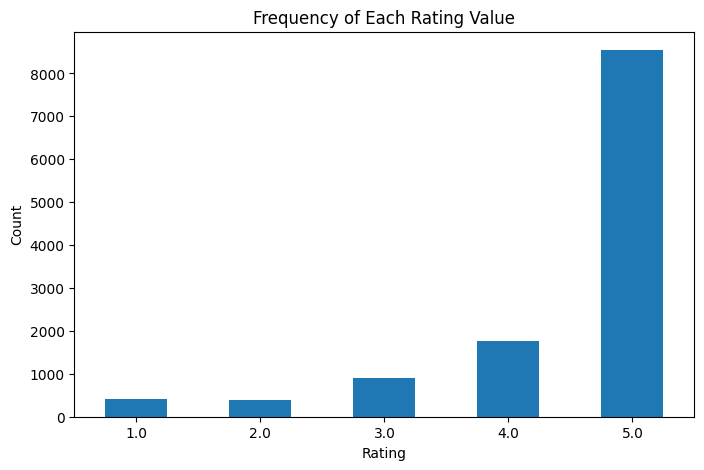

In [ ]:
# frequency of each rating

rating_counts = df['rating'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
rating_counts.plot(kind='bar')
plt.title("Frequency of Each Rating Value")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

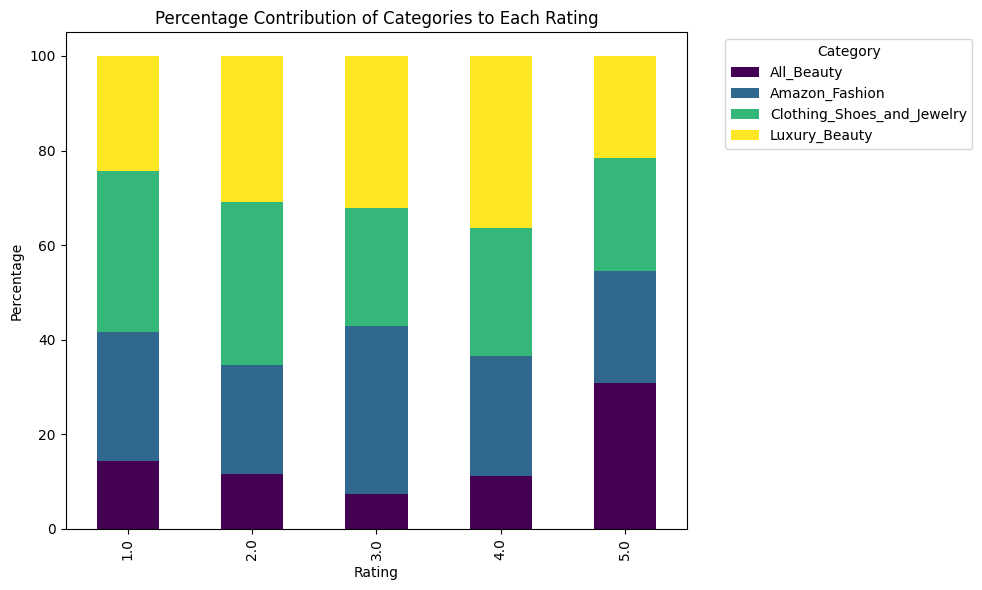

In [ ]:
# stacked bar chart - percentage contribution

rating_category_counts = df.groupby(['rating', 'category']).size().unstack(fill_value=0)

rating_category_percent = rating_category_counts.div(rating_category_counts.sum(axis=1), axis=0) * 100

rating_category_percent.plot(
    kind='bar', stacked=True, figsize=(10, 6), colormap='viridis'
)

plt.title("Percentage Contribution of Categories to Each Rating")
plt.xlabel("Rating")
plt.ylabel("Percentage")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

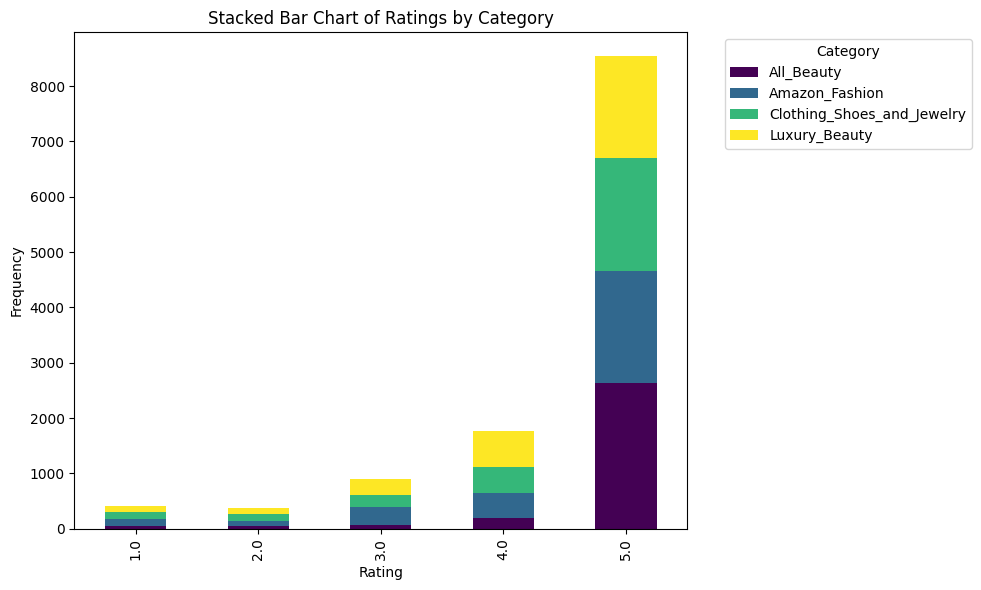

In [ ]:
# stacked bar chart - rating frequency

rating_category_counts = df.groupby(['rating', 'category']).size().unstack(fill_value=0)

rating_category_counts.plot(
    kind='bar', stacked=True, figsize=(10, 6), colormap='viridis'
)

plt.title("Stacked Bar Chart of Ratings by Category")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Average Rating per Category

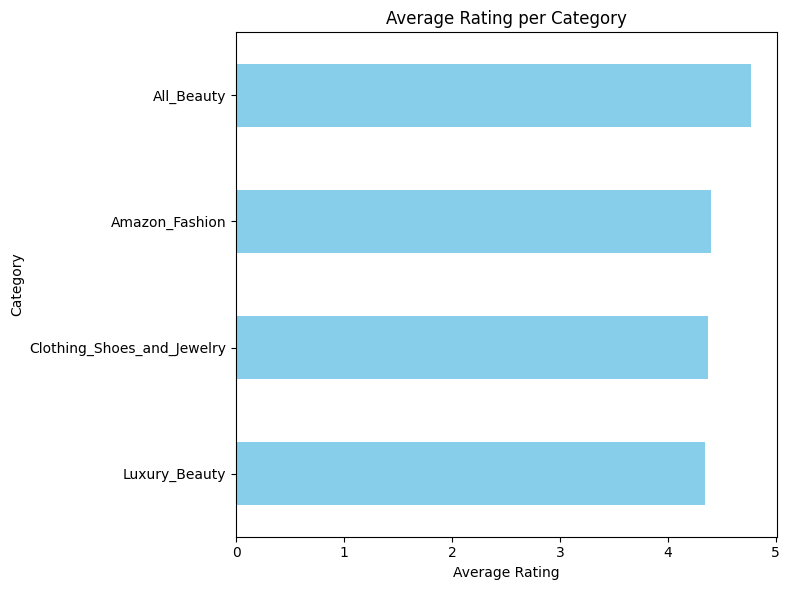

In [ ]:
avg_rating_per_category = df.groupby('category')['rating'].mean().sort_values()

plt.figure(figsize=(8, 6))
avg_rating_per_category.plot(kind='barh', color='skyblue')

plt.title("Average Rating per Category")
plt.xlabel("Average Rating")
plt.ylabel("Category")

plt.tight_layout()
plt.show()

## Top Words by Rating

In [ ]:
def get_top_words_per_rating(df, token_column, rating_column, top_n=10):
  top_words_per_rating = {}
  for rating in sorted(df[rating_column].unique()):
      tokens_list = df[df[rating_column] == rating][token_column].dropna().tolist()
      all_tokens = [word for tokens in tokens_list for word in eval(tokens)]
      top_words = Counter(all_tokens).most_common(top_n)
      top_words_per_rating[rating] = top_words
  return top_words_per_rating

def generate_wordclouds_per_rating(top_words_per_rating):
  for rating, word_freq in top_words_per_rating.items():
      print(f"Generating Wordcloud for Rating {rating}")
      wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(word_freq))
      plt.figure(figsize=(8, 4))
      plt.imshow(wordcloud, interpolation='bilinear')
      plt.title(f"Top Words for Rating {rating}")
      plt.axis('off')
      plt.show()

Generating Wordcloud for Rating 1.0


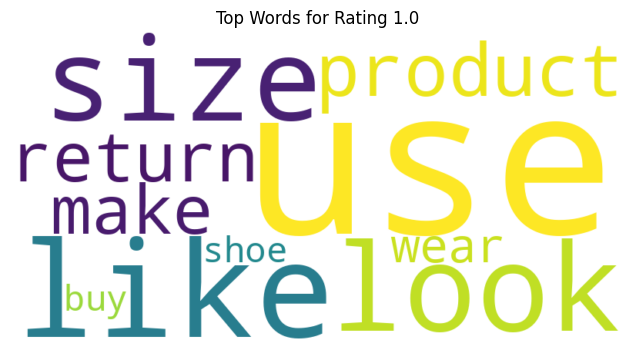

Generating Wordcloud for Rating 2.0


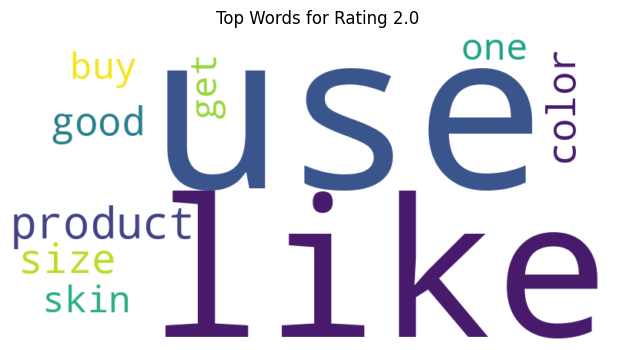

Generating Wordcloud for Rating 3.0


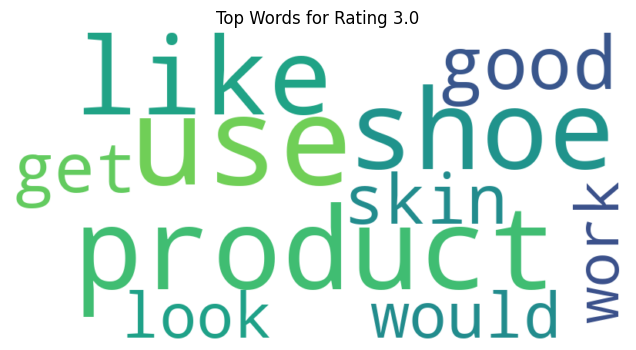

Generating Wordcloud for Rating 4.0


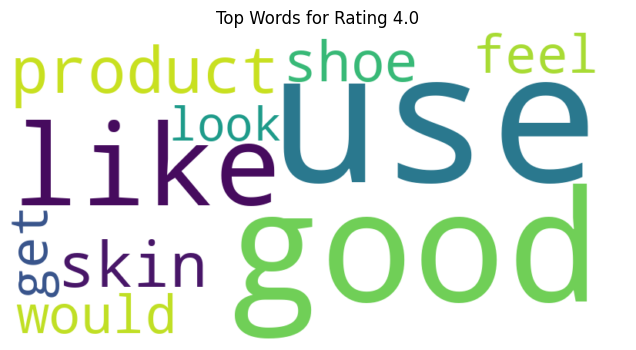

Generating Wordcloud for Rating 5.0


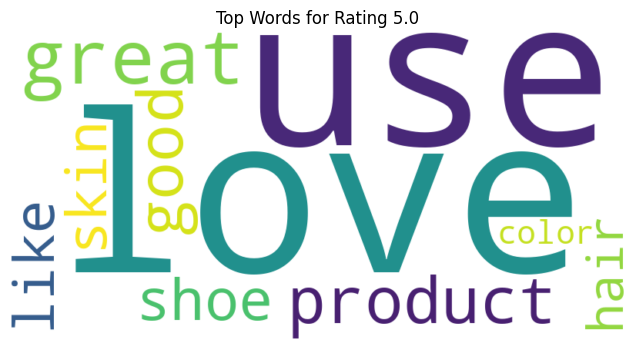

In [ ]:
top_words_per_rating = get_top_words_per_rating(df, token_column='reviewToken', rating_column='rating', top_n=10)

generate_wordclouds_per_rating(top_words_per_rating)

## Review Length by Rating

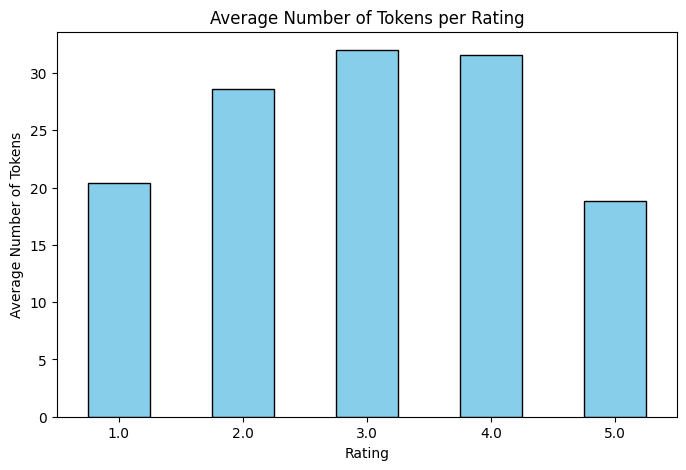

In [ ]:
def compute_avg_tokens_per_rating(df, token_column, rating_column):
  df['token_length'] = df[token_column].dropna().apply(lambda x: len(eval(x)))
  avg_tokens = df.groupby(rating_column)['token_length'].mean()
  return avg_tokens

avg_tokens_per_rating = compute_avg_tokens_per_rating(df, 'reviewToken', 'rating')

plt.figure(figsize=(8, 5))
avg_tokens_per_rating.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Average Number of Tokens per Rating")
plt.xlabel("Rating")
plt.ylabel("Average Number of Tokens")
plt.xticks(rotation=0)
plt.show()

## Time-Based Analysis

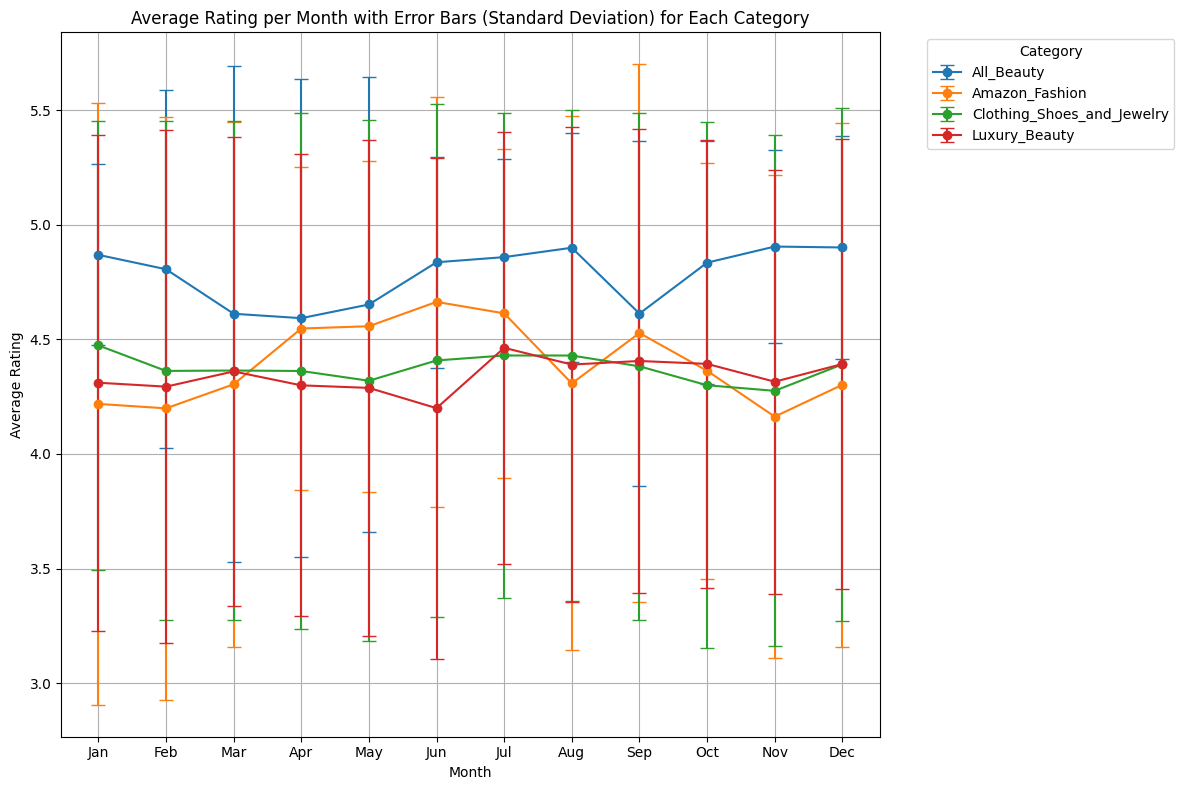

In [ ]:
df['reviewTime'] = pd.to_datetime(df['reviewTime'])

df['month'] = df['reviewTime'].dt.month

monthly_stats = df.groupby(['month', 'category'])['rating'].agg(['mean', 'std']).unstack()

plt.figure(figsize=(12, 8))
for category in monthly_stats['mean'].columns:
    mean_values = monthly_stats['mean'][category]
    std_values = monthly_stats['std'][category]

    plt.errorbar(mean_values.index, mean_values, yerr=std_values, capsize=5, fmt='-o', label=category)

plt.title("Average Rating per Month with Error Bars (Standard Deviation) for Each Category")
plt.xlabel("Month")
plt.ylabel("Average Rating")
plt.xticks(range(1, 13),
           ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

## Questions
*What were the answers to these questions?*  
What is the distribution of the ratings over categories and time?
In the plot above we can observe the ratings over categories and time. The category `All_Beauty` results in the highest score over every month. Therefore, we should think about taking this category for our fitting products.


# Data Exploration - Sentiment Analysis

## Load Data

In [ ]:
csv_path = '/content/drive/MyDrive/DOPP_Ex2_data/combined_reviews.csv'
df = pd.read_csv(csv_path)

## Sentiment Analysis

In [ ]:
def analyze_with_textblob(tokens):
  return TextBlob(str(tokens)).sentiment.polarity

In [ ]:
df['sentiment_score_text_blob'] = df['reviewText'].progress_apply(analyze_with_textblob)

100%|██████████| 12000/12000 [00:16<00:00, 714.90it/s]


In [ ]:
fig = px.box(df, x="category", y="sentiment_score_text_blob", color="category")
fig.show()

## Question
*What is the distribution of the sentiment over categories and time?*  
From the plot above, we can observe `All_Beauty` has the highest sentiment and `Luxury_Beauty` scores with the lowest sentiment out of these four categories. Another reason to stick with the `All_Beauty` category for suitable products when entering the market.

In [ ]:
fig = px.box(df, x="rating", y="sentiment_score_text_blob", color="rating", facet_col="category")
fig.show()

In [ ]:
fig = px.box(df, x="category", y="sentiment_score_text_blob", color="category", facet_col="rating")
fig.show()

Analyse data from the years 2016 to 2018, as there are too few upper data points in the period before that, which could lead to misunderstandings.

In [ ]:
df['reviewTime'] = pd.to_datetime(df['reviewTime'])
df = df[(df['reviewTime'] >= '2016-01-01') & (df['reviewTime'] <= '2018-12-31')]
df['month'] = df['reviewTime'].dt.to_period('M').dt.to_timestamp()

summary_stats = df.groupby(['month', 'category']).agg(
    mean_sentiment=('sentiment_score_text_blob', 'mean'),
    std_dev=('sentiment_score_text_blob', 'std')
).reset_index()

summary_stats

<ipython-input-38-62b1d62093c9>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,month,category,mean_sentiment,std_dev
0,2016-01-01,All_Beauty,0.533733,0.349716
1,2016-01-01,Amazon_Fashion,0.040264,0.113851
2,2016-01-01,Clothing_Shoes_and_Jewelry,0.353529,0.298267
3,2016-01-01,Luxury_Beauty,0.250302,0.289401
4,2016-02-01,All_Beauty,0.452919,0.326995
...,...,...,...,...
117,2018-06-01,Amazon_Fashion,0.311477,0.306455
118,2018-06-01,Luxury_Beauty,0.272538,0.219270
119,2018-07-01,Amazon_Fashion,0.507143,0.196564
120,2018-07-01,Luxury_Beauty,0.031031,0.185305


In [ ]:
summary_stats['max_std'] = summary_stats['mean_sentiment'] + summary_stats['std_dev']
summary_stats['min_std'] = summary_stats['mean_sentiment'] - summary_stats['std_dev']

for category in summary_stats['category'].unique():
    category_data = summary_stats[summary_stats['category'] == category]

    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=category_data['month'],
        y=category_data['mean_sentiment'],
        mode='lines+markers',
        name=f"{category} - Mean Sentiment",
        line=dict(width=2, color='blue'),
    ))

    fig.add_trace(go.Scatter(
        x=pd.concat([category_data['month'], category_data['month'][::-1]]),
        y=pd.concat([category_data['max_std'], category_data['min_std'][::-1]]),
        fill='toself',
        fillcolor='rgba(135, 206, 250, 0.3)',
        line=dict(width=0),
        hoverinfo="skip",
        showlegend=False,
    ))

    fig.update_layout(
        title=f"Sentiment Over Time for Category: {category}",
        xaxis_title="Month",
        yaxis_title="Sentiment Score",
        yaxis_range=[-1, 1],
        hovermode="x unified",
        template="plotly_white"
    )

    fig.show()

In [ ]:
df['month'] = df['reviewTime'].dt.month_name()

fig = px.box(
    df,
    x='month',
    y='sentiment_score_text_blob',
    color='category',
    title="Boxplot of Sentiment Values by Month",
    labels={'month': 'Month', 'sentiment_score_text_blob': 'Sentiment Score'}
)

fig.update_layout(
    xaxis_categoryorder='array',
    xaxis_categoryarray=['January', 'February', 'March', 'April', 'May', 'June',
                         'July', 'August', 'September', 'October', 'November', 'December'],
    yaxis_range=[-1.2, 1.2]
)

fig.show()

In [ ]:
df['month'] = pd.Categorical(df['month'],
                             categories=['January', 'February', 'March', 'April', 'May', 'June',
                                         'July', 'August', 'September', 'October', 'November', 'December'],
                             ordered=True)

for category in df['category'].unique():
    category_data = df[df['category'] == category]

    mean_sentiment_df = category_data.groupby('month', observed=True)['sentiment_score_text_blob'].mean().reset_index()

    fig = px.box(
        category_data,
        x='month',
        y='sentiment_score_text_blob',
        title=f"Boxplot of Sentiment Values by Month for Category: {category}",
        labels={'month': 'Month', 'sentiment_score_text_blob': 'Sentiment Score'}
    )

    fig.add_scatter(
        x=mean_sentiment_df['month'],
        y=mean_sentiment_df['sentiment_score_text_blob'],
        mode='lines+markers',
        name='Mean Sentiment',
        line=dict(color='black', width=2)
    )


    fig.update_layout(
        xaxis_categoryorder='array',
        xaxis_categoryarray=['January', 'February', 'March', 'April', 'May', 'June',
                             'July', 'August', 'September', 'October', 'November', 'December']
    )

    fig.show()

## Questions
*Were there any difficulties in analysing the data?*  
No

*What were the key insights obtained?*  
From our explorative analysis, we obtained that the category `All_Beauty` is the most favorable category to choose for our products.

*What are potential biases in the data and analysis?*
There are several biases in the data.
Once, the data is quite old and was collected from 1996 to 2018 and thus might be outdated.  
There is no further analysis possible with this data on which gender created what review and rating.
The ratings are highly imbalanced with mostly 5 star rating i.e. the best rating possible.  
For the analysis, the sentiment analysis might be biased due to the simple model we used.

## Save Data

In [ ]:
# change path if needed
output_path = '/content/drive/MyDrive/DOPP_Ex2_data/reviews_sentiment.csv'
df.to_csv(output_path, index=False)

# Data Modeling

In [ ]:
# change if needed
folder_path = '/content/drive/MyDrive/'

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Reading the CSV File

In [ ]:
# change if you already have the file downloaded
csv_path = '/content/drive/MyDrive/DOPP_Ex2_data/combined_reviews.csv'
df = pd.read_csv(csv_path)

## Build the Model

In [ ]:
# Preprocessing
def preprocess_text(text):
    # Convert only string instances to lowercase
    text = text.lower() if isinstance(text, str)  else ''
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = text.split()
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)


df['preprocessedText'] = df['reviewText'].apply(preprocess_text)

# Tokenize text again for word2vec
df['tokenized_text'] = df['preprocessedText'].str.split()

df['preprocessedText'].head()

,preprocessedText
0,great product wanted works great stylish
1,seeing popularity shoe decided test impressed ...
2,nervousness scent ive never tried love paul mi...
3,love smell bit expensive cant buy often would ...
4,found stuff japan wondered could find 3drops g...


In [ ]:
y = df['rating']
X = pd.DataFrame({'preprocessedText': df['preprocessedText'], 'tokenized_text': df['tokenized_text'], 'reviewText': df["reviewText"]})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Combine train and test sets
df_train = pd.DataFrame({'preprocessedText': X_train['preprocessedText'], 'tokenized_text': X_train['tokenized_text'], 'reviewText': X_train["reviewText"], 'rating': y_train})
df_test = pd.DataFrame({'preprocessedText': X_test['preprocessedText'], 'tokenized_text': X_test['tokenized_text'], 'reviewText': X_test["reviewText"], 'rating': y_test})

# Save them into csv files
df_train.to_csv(folder_path + 'train.csv', index=True)
df_test.to_csv(folder_path + 'test.csv', index=True)

In [ ]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer()
X_tfidf_train = tfidf.fit_transform(X_train['preprocessedText']).toarray()
X_tfidf_test = tfidf.transform(X_test['preprocessedText']).toarray()

# Word2Vec Embeddings
w2v_model_train = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)

def get_sentence_embedding(word_list, model):
    word_vecs = [model.wv[word] for word in word_list if word in model.wv]
    if word_vecs:
        return np.mean(word_vecs, axis=0)
    else:
        return np.zeros(model.vector_size)

X_w2v_train = np.array([get_sentence_embedding(word_list, w2v_model_train) for word_list in X_train['tokenized_text']])
X_w2v_test = np.array([get_sentence_embedding(word_list, w2v_model_train) for word_list in X_test['tokenized_text']])

X_train_vectorized = np.hstack((X_tfidf_train, X_w2v_train))
X_test_vectorized = np.hstack((X_tfidf_test, X_w2v_test))

## Including wandb for Analysis during Model Trainig

In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
wandb_project_name = "DOPP analysis"
wandb_run_name = "rf_experiment-10"

rf_config = {
    "n_estimators": 100,
    "max_depth": None,
    "random_state": 42,
    "test_size": 0.2,
    "dataset": "Word2Vec"
}


wandb.init(
    project=wandb_project_name,
    name=wandb_run_name,
    config=rf_config
)


start_time = time.time()

rf_model = RandomForestClassifier(
    n_estimators=rf_config["n_estimators"],
    max_depth=rf_config["max_depth"],
    random_state=rf_config["random_state"]
)
rf_model.fit(X_train_vectorized, y_train)

y_pred_rf = rf_model.predict(X_test_vectorized)
end_time = time.time()
execution_time = end_time - start_time

f1Score = f1_score(y_test, y_pred_rf, average='macro')
precision = precision_score(y_test, y_pred_rf, average='macro')
recall = recall_score(y_test, y_pred_rf, average='macro')

# Log metrics to W&B
wandb.log({
    "Execution Time": execution_time,
    "F1 Score": f1Score,
    "Precision Score": precision,
    "Recall Score": recall
})

print("Execution Time:", execution_time, "seconds")
print("Precision Score:", precision)
print("Recall Score:", recall)
print("F1 Score:", f1Score, "\n")
print(classification_report(y_test, y_pred_rf))

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

wandb: Currently logged in as: l-beccard (l-beccard-tu-wien). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Execution Time: 142.51742434501648 seconds
Precision Score: 0.8809310081132928
Recall Score: 0.4893494597601945
F1 Score: 0.5915729568156776 

              precision    recall  f1-score   support

         1.0       0.77      0.35      0.48        68
         2.0       0.97      0.38      0.55        73
         3.0       0.99      0.37      0.54       182
         4.0       0.88      0.34      0.49       351
         5.0       0.80      0.99      0.89      1726

    accuracy                           0.81      2400
   macro avg       0.88      0.49      0.59      2400
weighted avg       0.83      0.81      0.78      2400



Execution Time,▁
F1 Score,▁
Precision Score,▁
Recall Score,▁
Execution Time,142.51742
F1 Score,0.59157
Precision Score,0.88093
Recall Score,0.48935


In [ ]:
svc_config = {
    "random_state": 42,
    "test_size": 0.2,
    "max_iter": 1000,
    "penalty": "l1",
    "dataset": "Combined"
}

wandb_project_name = "DOPP analysis"

wandb.init(
    project=wandb_project_name,
    name="svc_experiment-4",
    config=svc_config
)

start_time = time.time()

linear_svc_model = LinearSVC(random_state=svc_config["random_state"], penalty=svc_config["penalty"])
linear_svc_model.fit(X_train_vectorized, y_train)

y_pred_svc = linear_svc_model.predict(X_test_vectorized)
end_time = time.time()
execution_time = end_time - start_time

f1Score = f1_score(y_test, y_pred_svc, average='macro')
precision = precision_score(y_test, y_pred_svc, average='macro')
recall = recall_score(y_test, y_pred_svc, average='macro')

wandb.log({
    "Execution Time": execution_time,
    "F1 Score": f1Score,
    "Precision Score": precision,
    "Recall Score": recall
})

print("Execution Time:", execution_time, "seconds")
print("Precision Score:", precision)
print("Recall Score:", recall)
print("F1 Score:", f1Score, "\n")
print(classification_report(y_test, y_pred_svc))

wandb.finish()

Execution Time: 1.7085254192352295 seconds
Precision Score: 0.6633378211874695
Recall Score: 0.516365226302919
F1 Score: 0.5710940107187673 

              precision    recall  f1-score   support

         1.0       0.57      0.38      0.46        68
         2.0       0.68      0.38      0.49        73
         3.0       0.61      0.40      0.48       182
         4.0       0.60      0.47      0.53       351
         5.0       0.86      0.95      0.90      1726

    accuracy                           0.81      2400
   macro avg       0.66      0.52      0.57      2400
weighted avg       0.79      0.81      0.79      2400



Execution Time,▁
F1 Score,▁
Precision Score,▁
Recall Score,▁
Execution Time,1.70853
F1 Score,0.57109
Precision Score,0.66334
Recall Score,0.51637


## Qualitative Misclassification Analysis

In [ ]:
false_preds_svc = y_pred_svc != y_test

misclassified_predictions = y_pred_svc[false_preds_svc]
misclassified_labels = y_test[false_preds_svc]

In [ ]:
np.unique(misclassified_predictions, return_counts=True)

(array([1., 2., 3., 4., 5.]), array([ 20,  13,  46, 108, 278]))

By this frequency count, it is observable that most of the time a 5-star-rating is predicting wrong, which makes sense since the original dataset is quite imbalanced. The grade 2 has been misclassified the least but is also the least represented class in the dataset.

In [ ]:
df_misclassified = df.iloc[misclassified_labels.index]

In [ ]:
df_misclassified["misclassified_rating"] = misclassified_predictions

<ipython-input-63-38338740226b>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_misclassified.iloc[0]

,6494
rating,3.0
reviewTime,2014-08-18
reviewerID,AOEUN9718KVRD
reviewText,The foam conditioner is easy to use and doesn'...
summary,Don't like the scent.
unixReviewTime,1408320000
category,All_Beauty
reviewToken,"['foam', 'conditioner', 'easy', 'use', 'leave'..."
preprocessedText,foam conditioner easy use doesnt leave greasy ...
tokenized_text,"[foam, conditioner, easy, use, doesnt, leave, ..."


In [ ]:
df_misclassified.iloc[0]["reviewText"]

"The foam conditioner is easy to use and doesn't leave greasy residue on hair. There was no problem in rinsing it off.\nI just don't like the smell, it bothers me. It's very chemical."

Based on the review text, we can observe that the model does not really understand the final critizing words of the this review. The review text itself is reasonable to give this three stars.

In [ ]:
df_misclassified.iloc[14]

,11815
rating,4.0
reviewTime,2015-05-14
reviewerID,A22HY3D260KUAW
reviewText,One of my recent samples has been Mario Badesc...
summary,I like the way it makes my skin tight
unixReviewTime,1431561600
category,Luxury_Beauty
reviewToken,"['one', 'recent', 'sample', 'mario', 'badescu'..."
preprocessedText,one recent samples mario badescu skin care pro...
tokenized_text,"[one, recent, samples, mario, badescu, skin, c..."


In [ ]:
df_misclassified.iloc[14]["reviewText"]

'One of my recent samples has been Mario Badescu Skin Care Products. I started off with the Almond and Honey Face Scrub which was a pretty gentle scrub. It smells AWESOME, I am a big fan of the sweet almond scent! I give this scent 5 stars :-) I scrubbed it onto my moistened face and rinsed it off, it left my skin feeling very clean and soft. I then applied some of the Seaweed Cleansing Lotion (toner) it smelled pretty plain and earthy. The Seaweed scent was just ok, but it left my skin feeling clean and tight. Next I applied a small amount of the Ceramide Herbal Eye Cream. It smells like a non-scented lotion. This was just ok. I then massaged the Hyaluronic Moisturizer (SPF 15) into my face and neck which also smells like a non-scented lotion. It went on light, its not really thick, which I liked. Out of all these products I loved the Almond and Honey Scrub & the rest of the products were just ok.'

Again, the review text presents some kind of critique, which should be understood by the model not to rate it with five stars.

In [ ]:
# Pick only ratings with 1
df_misclassified_1 = df_misclassified[df_misclassified["misclassified_rating"] == 1]
df_misclassified_1.iloc[1]

,1121
rating,4.0
reviewTime,2015-01-16
reviewerID,A383TEVMZD2A6S
reviewText,I ordered wrong size.
summary,Four Stars
unixReviewTime,1421366400
category,Clothing_Shoes_and_Jewelry
reviewToken,"['order', 'wrong', 'size']"
preprocessedText,ordered wrong size
tokenized_text,"[ordered, wrong, size]"


In [ ]:
df_misclassified_1.iloc[1]["reviewText"]

'I ordered wrong size.'

In [ ]:
df_misclassified_1.iloc[1]["reviewToken"]

"['order', 'wrong', 'size']"

This is an interesting case since we have the opposite behaviour of the model now predicting a higher rated product of 4 with a lower rating of 1. We can assume that the word wrong is leading to such a prediction.

## Balancing Optimizations

In [ ]:
df_train["rating"].value_counts()

,count
rating,
5.0,6820
4.0,1414
3.0,722
1.0,338
2.0,306


We have only 306 two star ratings as the least represented class. Therefore, we will take only 306 random samples from the other classes.

In [ ]:
df_rating_2 = df_train[df_train["rating"] == 2]

In [ ]:
df_rating_1 = df_train[df_train["rating"] == 1].sample(n=306, random_state=42)
df_rating_3 = df_train[df_train["rating"] == 3].sample(n=306, random_state=42)
df_rating_4 = df_train[df_train["rating"] == 4].sample(n=306, random_state=42)
df_rating_5 = df_train[df_train["rating"] == 5].sample(n=306, random_state=42)

In [ ]:
# Merge all dataframes
df_balanced = pd.concat([df_rating_2, df_rating_1, df_rating_3, df_rating_4, df_rating_5])

In [ ]:
df_balanced.shape

(1530, 4)

In [ ]:
df_balanced["rating"].value_counts()

,count
rating,
2.0,306
1.0,306
3.0,306
4.0,306
5.0,306


In [ ]:
df_balanced.head()

,preprocessedText,tokenized_text,reviewText,rating
10238,feel like got large 68,"[feel, like, got, large, 68]",feel like I should have got a large.\n\ni am a...,2.0
3499,purchased product read review amazoncom well f...,"[purchased, product, read, review, amazoncom, ...",I purchased this product when I read a review ...,2.0
1026,2 coats topcoat still chipped thought price wo...,"[2, coats, topcoat, still, chipped, thought, p...",2 coats and a topcoat and still it chipped. T...,2.0
10506,email query received listed site converse mens...,"[email, query, received, listed, site, convers...",This is the email query I received.... the wer...,2.0
6728,long walking tougher barefoot,"[long, walking, tougher, barefoot]",Long walking is tougher than barefoot,2.0


In [ ]:
y_train_balanced = df_balanced['rating']

X_tfidf_train_balanced = tfidf.fit_transform(df_balanced['preprocessedText']).toarray()
X_tfidf_test_balanced = tfidf.transform(X_test['preprocessedText']).toarray()

# Using w2v model with train set only as recommended here: https://stackoverflow.com/a/70900433/19932351
X_w2v_train_balanced = np.array([get_sentence_embedding(word_list, w2v_model_train) for word_list in df_balanced['tokenized_text']])
X_w2v_test_balanced = np.array([get_sentence_embedding(word_list, w2v_model_train) for word_list in X_test['tokenized_text']])

X_train_vectorized_balanced = np.hstack((X_tfidf_train_balanced, X_w2v_train_balanced))
X_test_vectorized_balanced = np.hstack((X_tfidf_test_balanced, X_w2v_test_balanced))

In [ ]:
X_train_vectorized_balanced.shape

(1530, 5877)

In [ ]:
X_test_vectorized_balanced.shape

(2400, 5877)

In [ ]:
wandb_project_name = "DOPP analysis"
wandb_run_name = "rf_balanced-2-estimators-100"

rf_config = {
    "n_estimators": 100,
    "max_depth": None,
    "random_state": 42,
    "test_size": 0.2,
    "dataset": "Balanced-Combined"
}


wandb.init(
    project=wandb_project_name,
    name=wandb_run_name,
    config=rf_config
)


start_time = time.time()

rf_model = RandomForestClassifier(
    n_estimators=rf_config["n_estimators"],
    max_depth=rf_config["max_depth"],
    random_state=rf_config["random_state"]
)
rf_model.fit(X_train_vectorized_balanced, y_train_balanced)

y_pred_rf = rf_model.predict(X_test_vectorized_balanced)
end_time = time.time()
execution_time = end_time - start_time

f1Score = f1_score(y_test, y_pred_rf, average='macro')
precision = precision_score(y_test, y_pred_rf, average='macro')
recall = recall_score(y_test, y_pred_rf, average='macro')

# Log metrics to W&B
wandb.log({
    "Execution Time": execution_time,
    "F1 Score": f1Score,
    "Precision Score": precision,
    "Recall Score": recall
})

print("Execution Time:", execution_time, "seconds")
print("Precision Score:", precision)
print("Recall Score:", recall)
print("F1 Score:", f1Score, "\n")
print(classification_report(y_test, y_pred_rf))

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()


Execution Time: 3.6765294075012207 seconds
Precision Score: 0.43000363773035327
Recall Score: 0.5496563911596176
F1 Score: 0.46494174468149074 

              precision    recall  f1-score   support

         1.0       0.27      0.46      0.34        68
         2.0       0.29      0.58      0.38        73
         3.0       0.32      0.45      0.38       182
         4.0       0.35      0.57      0.43       351
         5.0       0.92      0.70      0.80      1726

    accuracy                           0.65      2400
   macro avg       0.43      0.55      0.46      2400
weighted avg       0.76      0.65      0.69      2400



Execution Time,▁
F1 Score,▁
Precision Score,▁
Recall Score,▁
Execution Time,3.67653
F1 Score,0.46494
Precision Score,0.43
Recall Score,0.54966


In [ ]:
svc_config = {
    "random_state": 42,
    "test_size": 0.2,
    "max_iter": 1000,
    "penalty": "l2",
    "dataset": "Balanced-Combined"
}

wandb_project_name = "DOPP analysis"

wandb.init(
    project=wandb_project_name,
    name="svc_balanced",
    config=svc_config
)

start_time = time.time()

linear_svc_model = LinearSVC(random_state=svc_config["random_state"], penalty=svc_config["penalty"])
linear_svc_model.fit(X_train_vectorized_balanced, y_train_balanced)

y_pred_svc = linear_svc_model.predict(X_test_vectorized_balanced)
end_time = time.time()
execution_time = end_time - start_time

f1Score = f1_score(y_test, y_pred_svc, average='macro')
precision = precision_score(y_test, y_pred_svc, average='macro')
recall = recall_score(y_test, y_pred_svc, average='macro')

wandb.log({
    "Execution Time": execution_time,
    "F1 Score": f1Score,
    "Precision Score": precision,
    "Recall Score": recall
})

print("Execution Time:", execution_time, "seconds")
print("Precision Score:", precision)
print("Recall Score:", recall)
print("F1 Score:", f1Score, "\n")
print(classification_report(y_test, y_pred_svc))

wandb.finish()

Execution Time: 0.1361532211303711 seconds
Precision Score: 0.3991277698172116
Recall Score: 0.5576925754959859
F1 Score: 0.4316517105973183 

              precision    recall  f1-score   support

         1.0       0.24      0.57      0.34        68
         2.0       0.21      0.58      0.31        73
         3.0       0.30      0.48      0.37       182
         4.0       0.32      0.54      0.40       351
         5.0       0.93      0.62      0.74      1726

    accuracy                           0.59      2400
   macro avg       0.40      0.56      0.43      2400
weighted avg       0.75      0.59      0.64      2400



Execution Time,▁
F1 Score,▁
Precision Score,▁
Recall Score,▁
Execution Time,0.13615
F1 Score,0.43165
Precision Score,0.39913
Recall Score,0.55769


By the metrices, we can observe that both models do not improve their overall performances. Even the minority classes are not more correctly predicted than in the default dataset. We assume this is because of the smaller train set size.

## Oversampling

In [ ]:
df_rating_1 = df_train[df_train["rating"] == 1]
df_rating_2 = df_train[df_train["rating"] == 2]
df_rating_3 = df_train[df_train["rating"] == 3]
df_rating_4 = df_train[df_train["rating"] == 4]
df_rating_5 = df_train[df_train["rating"] == 5]
print("1",len(df_rating_1))
print("2", len(df_rating_2))
print("3", len(df_rating_3))
print("4",len(df_rating_4))
print("5", len(df_rating_5))

1 338
2 306
3 722
4 1414
5 6820


In our next approach, we target the sample count of 1414, which is the count of class 4, the second most represented class. Therefore, we have to oversample classes 1 to 3 and undersample the majority class 5.

In [ ]:
df_rating_1 = df_train[df_train["rating"] == 1].sample(n=1414, random_state=42, replace=True)
df_rating_2 = df_train[df_train["rating"] == 2].sample(n=1414, random_state=42, replace=True)
df_rating_3 = df_train[df_train["rating"] == 3].sample(n=1414, random_state=42, replace=True)
df_rating_5 = df_train[df_train["rating"] == 5].sample(n=1414, random_state=42)

In [ ]:
df_oversampled = pd.concat([df_rating_2, df_rating_1, df_rating_3, df_rating_4, df_rating_5])

In [ ]:
df_oversampled["rating"].value_counts()

,count
rating,
2.0,1414
1.0,1414
3.0,1414
4.0,1414
5.0,1414


In [ ]:
y_train_oversampled = df_oversampled['rating']

X_tfidf_train_oversampled = tfidf.fit_transform(df_oversampled['preprocessedText']).toarray()
X_tfidf_test_oversampled = tfidf.transform(X_test['preprocessedText']).toarray()

# Using w2v model with train set only as recommended here: https://stackoverflow.com/a/70900433/19932351
X_w2v_train_oversampled = np.array([get_sentence_embedding(word_list, w2v_model_train) for word_list in df_oversampled['tokenized_text']])
X_w2v_test_oversampled = np.array([get_sentence_embedding(word_list, w2v_model_train) for word_list in X_test['tokenized_text']])

X_train_vectorized_oversampled = np.hstack((X_tfidf_train_oversampled, X_w2v_train_oversampled))
X_test_vectorized_oversampled = np.hstack((X_tfidf_test_oversampled, X_w2v_test_oversampled))

In [ ]:
wandb_project_name = "DOPP analysis"
wandb_run_name = "rf_oversampled"

rf_config = {
    "n_estimators": 100,
    "max_depth": None,
    "random_state": 42,
    "test_size": 0.2,
    "dataset": "Oversampled-Combined"
}


wandb.init(
    project=wandb_project_name,
    name=wandb_run_name,
    config=rf_config
)


start_time = time.time()

rf_model = RandomForestClassifier(
    n_estimators=rf_config["n_estimators"],
    max_depth=rf_config["max_depth"],
    random_state=rf_config["random_state"]
)
rf_model.fit(X_train_vectorized_oversampled, y_train_oversampled)

y_pred_rf = rf_model.predict(X_test_vectorized_oversampled)
end_time = time.time()
execution_time = end_time - start_time

f1Score = f1_score(y_test, y_pred_rf, average='macro')
precision = precision_score(y_test, y_pred_rf, average='macro')
recall = recall_score(y_test, y_pred_rf, average='macro')

# Log metrics to W&B
wandb.log({
    "Execution Time": execution_time,
    "F1 Score": f1Score,
    "Precision Score": precision,
    "Recall Score": recall
})

print("Execution Time:", execution_time, "seconds")
print("Precision Score:", precision)
print("Recall Score:", recall)
print("F1 Score:", f1Score, "\n")
print(classification_report(y_test, y_pred_rf))

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

Execution Time: 50.13351511955261 seconds
Precision Score: 0.6533820401226568
Recall Score: 0.5490315971025749
F1 Score: 0.5673749938122136 

              precision    recall  f1-score   support

         1.0       0.53      0.41      0.46        68
         2.0       0.76      0.40      0.52        73
         3.0       0.68      0.39      0.50       182
         4.0       0.38      0.74      0.50       351
         5.0       0.92      0.80      0.86      1726

    accuracy                           0.74      2400
   macro avg       0.65      0.55      0.57      2400
weighted avg       0.80      0.74      0.76      2400



Execution Time,▁
F1 Score,▁
Precision Score,▁
Recall Score,▁
Execution Time,50.13352
F1 Score,0.56737
Precision Score,0.65338
Recall Score,0.54903


In [ ]:
svc_config = {
    "random_state": 42,
    "test_size": 0.2,
    "max_iter": 1000,
    "penalty": "l2",
    "dataset": "Oversampled-Combined"
}

wandb_project_name = "DOPP analysis"

wandb.init(
    project=wandb_project_name,
    name="svc_balanced",
    config=svc_config
)

start_time = time.time()

linear_svc_model = LinearSVC(random_state=svc_config["random_state"], penalty=svc_config["penalty"])
linear_svc_model.fit(X_train_vectorized_oversampled, y_train_oversampled)

y_pred_svc = linear_svc_model.predict(X_test_vectorized_oversampled)
end_time = time.time()
execution_time = end_time - start_time

f1Score = f1_score(y_test, y_pred_svc, average='macro')
precision = precision_score(y_test, y_pred_svc, average='macro')
recall = recall_score(y_test, y_pred_svc, average='macro')

wandb.log({
    "Execution Time": execution_time,
    "F1 Score": f1Score,
    "Precision Score": precision,
    "Recall Score": recall
})

print("Execution Time:", execution_time, "seconds")
print("Precision Score:", precision)
print("Recall Score:", recall)
print("F1 Score:", f1Score, "\n")
print(classification_report(y_test, y_pred_svc))

wandb.finish()

Execution Time: 0.5500369071960449 seconds
Precision Score: 0.4991385022698241
Recall Score: 0.5691498052091545
F1 Score: 0.52035302821631 

              precision    recall  f1-score   support

         1.0       0.34      0.43      0.38        68
         2.0       0.41      0.51      0.45        73
         3.0       0.45      0.49      0.47       182
         4.0       0.37      0.68      0.47       351
         5.0       0.93      0.74      0.82      1726

    accuracy                           0.70      2400
   macro avg       0.50      0.57      0.52      2400
weighted avg       0.78      0.70      0.72      2400



Execution Time,▁
F1 Score,▁
Precision Score,▁
Recall Score,▁
Execution Time,0.55004
F1 Score,0.52035
Precision Score,0.49914
Recall Score,0.56915


## Data Augmentation

### Azurae AI Translation

We have used the Round-Trip translation method, i.e. we translate the text into another language and back again to obtain a slightly different wording without changing the meaning. In our case, we have rewritten the text: English → German → French → English. We used Azurae API as we received some free credits.

As we need an API key for the execution, we have decided to only include the code here and display the translated texts, as this is time- and resource-consuming.

In [ ]:
#key =
#location =
#endpoint = "https://api.cognitive.microsofttranslator.com"
#path = "/translate"

#constructed_url = endpoint + path

#headers = {
#    'Ocp-Apim-Subscription-Key': key,
#    'Ocp-Apim-Subscription-Region': location,
#    'Content-type': 'application/json',
#    'X-ClientTraceId': str(uuid.uuid4())
#}

In [ ]:
#def translate_text(text, from_lang, to_lang, max_retries=5):
#    if not text:
#        return None

#    params = {
#        'api-version': '3.0',
#        'from': from_lang,
#        'to': [to_lang]
#    }
#    body = [{'text': text}]
#    retries = 0

#   while retries <= max_retries:
#        try:
#            response = requests.post(constructed_url, params=params, headers=headers, json=body)
#            response.raise_for_status()
#            translated_text = response.json()[0]['translations'][0]['text']
#            return translated_text
#        except requests.exceptions.HTTPError as e:
#            if response.status_code == 429:
#                retries += 1
#                wait_time = 2 ** retries
#                time.sleep(wait_time)
#            else:
#                print(f"HTTP Error: {e}")
#                break
#        except Exception as e:
#            print(f"Error translating text: {e}")
#            break

#    return None

In [ ]:
#df['reviewText_german'] = df.progress_apply(
#    lambda row: translate_text(row['reviewText'], from_lang='en', to_lang='de'), axis=1)

In [ ]:
#df['reviewText_german_french'] = df.progress_apply(
#    lambda row: translate_text(row['reviewText_german'], from_lang='de', to_lang='fr'), axis=1)

In [ ]:
#df['reviewText_german_french_english'] = df.progress_apply(
#    lambda row: translate_text(row['reviewText_german_french'], from_lang='fr', to_lang='en'), axis=1)

In [ ]:
#df_train = pd.read_csv("./content/drive/MyDrive/DOPP_Ex2_data/train.csv")
#df_train.info()

In [ ]:
#df_wide_subset = df[['reviewText', 'reviewText_german', 'reviewText_german_french', 'reviewText_german_french_english']]
#df_merged = pd.merge(df_train, df_wide_subset, on='reviewText', how='left')

In [ ]:
#output_path = './content/drive/MyDrive/DOPP_Ex2_data/reviews_train_wide.csv'
#df_merged.to_csv(output_path, index=False)

In [ ]:
#long_df = pd.melt(
#    df_merged,
#    id_vars=['rating'],
#    value_vars=['reviewText', 'reviewText_german_french_english'],
#    var_name='text_type',
#    value_name='reviewText_long'
#)
#long_df.rename(columns={'reviewText_long': 'reviewText'}, inplace=True)

In [ ]:
#output_path = './content/drive/MyDrive/DOPP_Ex2_data/reviews_train_long.csv'
#long_df = long_df.dropna(subset=['reviewText'])
#long_df.to_csv(output_path, index=False)

Compare translations

In [ ]:
df_wide = pd.read_csv('/content/drive/MyDrive/DOPP_Ex2_data/reviews_train_wide.csv')

In [ ]:
def compare_translations(df, index):

    label = df.loc[index, 'rating']
    original_text = df.loc[index, 'reviewText']
    german_text = df.loc[index, 'reviewText_german']
    german_french_text = df.loc[index, 'reviewText_german_french']
    final_text = df.loc[index, 'reviewText_german_french_english']

    print(f"Index: {index}")
    print(f"****")
    print(f"Label: {label}")
    print(f"****")
    print(f"Original Text: {original_text}")
    print(f"****")
    print(f"German Translation: {german_text}")
    print(f"****")
    print(f"German-French Translation: {german_french_text}")
    print(f"****")
    print(f"Back-Translated Text: {final_text}")
    print("")

In [ ]:
compare_translations(df_wide,2)

Index: 2
****
Label: 5.0
****
Original Text: I do my own nails at home and love CND Shellac. It is a great prodct and truly does last at least 14 days. My nails always look amazing and I get a ton of compliments. I also love the colors and the option to layer and create new colors is awesome.
****
German Translation: Ich mache meine eigenen Nägel zu Hause und liebe CND Shellac. Es ist ein großartiges Produkt und hält wirklich mindestens 14 Tage. Meine Nägel sehen immer fantastisch aus und ich bekomme eine Menge Komplimente. Ich liebe auch die Farben und die Möglichkeit, neue Farben zu schichten und zu erstellen, ist großartig.
****
German-French Translation: Je me fais mes propres ongles à la maison et j’adore CND Shellac. C’est un excellent produit qui dure vraiment au moins 14 jours. Mes ongles sont toujours magnifiques et je reçois beaucoup de compliments. J’aime aussi les couleurs et la possibilité de superposer et de créer de nouvelles couleurs est géniale.
****
Back-Translated Te

### Train model with DA

In [ ]:
csv_path = '/content/drive/MyDrive/DOPP_Ex2_data/reviews_train_long.csv'
df_da = pd.read_csv(csv_path)

In [ ]:
df_da = df_da.sample(frac=1).reset_index(drop=True)
df_da.head(2)

,rating,text_type,reviewText
0,4.0,reviewText,The shoes are true to size. I am used to weari...
1,5.0,reviewText,My daughter loves them. Great fit!


In [ ]:
df_da['preprocessedText'] = df_da['reviewText'].apply(preprocess_text)
df_da['tokenized_text'] = df_da['preprocessedText'].str.split()

In [ ]:
y_train_da = df_da['rating']

tfidf = TfidfVectorizer()
X_tfidf_train_da =  tfidf.fit_transform(df_da['preprocessedText']).toarray().astype(np.float32)
X_tfidf_test_da = tfidf.transform(X_test['preprocessedText']).toarray().astype(np.float32)

# Word2Vec Embeddings
w2v_model_train = Word2Vec(sentences=df_da['tokenized_text'], vector_size=100, window=5, min_count=1, workers=4)

X_w2v_train_da = np.array([get_sentence_embedding(word_list, w2v_model_train) for word_list in df_da['tokenized_text']], dtype=np.float32)
X_w2v_test_da = np.array([get_sentence_embedding(word_list, w2v_model_train) for word_list in X_test['tokenized_text']], dtype=np.float32)


In [ ]:
X_train_vectorized_da = np.hstack((X_tfidf_train_da, X_w2v_train_da))
X_test_vectorized_da = np.hstack((X_tfidf_test_da, X_w2v_test_da))

In [ ]:
wandb_project_name = "DOPP analysis"
wandb_run_name = "rf_da"

rf_config = {
    "n_estimators": 100,
    "max_depth": None,
    "random_state": 42,
    "test_size": 0.2,
    "dataset": "Data-Augmentation"
}


wandb.init(
    project=wandb_project_name,
    name=wandb_run_name,
    config=rf_config
)


start_time = time.time()

rf_model = RandomForestClassifier(
    n_estimators=rf_config["n_estimators"],
    max_depth=rf_config["max_depth"],
    random_state=rf_config["random_state"]
)
rf_model.fit(X_train_vectorized_da, y_train_da)

y_pred_rf = rf_model.predict(X_test_vectorized_da)
end_time = time.time()
execution_time = end_time - start_time

f1Score = f1_score(y_test, y_pred_rf, average='macro')
precision = precision_score(y_test, y_pred_rf, average='macro')
recall = recall_score(y_test, y_pred_rf, average='macro')

# Log metrics to W&B
wandb.log({
    "Execution Time": execution_time,
    "F1 Score": f1Score,
    "Precision Score": precision,
    "Recall Score": recall
})

print("Execution Time:", execution_time, "seconds")
print("Precision Score:", precision)
print("Recall Score:", recall)
print("F1 Score:", f1Score, "\n")
print(classification_report(y_test, y_pred_rf))

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

wandb: Currently logged in as: l-beccard (l-beccard-tu-wien). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Execution Time: 456.6549406051636 seconds
Precision Score: 0.9351453348142822
Recall Score: 0.4722057449235191
F1 Score: 0.5803893084635691 

              precision    recall  f1-score   support

         1.0       0.96      0.32      0.48        68
         2.0       1.00      0.37      0.54        73
         3.0       0.98      0.36      0.52       182
         4.0       0.94      0.31      0.47       351
         5.0       0.79      1.00      0.88      1726

    accuracy                           0.81      2400
   macro avg       0.94      0.47      0.58      2400
weighted avg       0.84      0.81      0.77      2400



Execution Time,▁
F1 Score,▁
Precision Score,▁
Recall Score,▁
Execution Time,456.65494
F1 Score,0.58039
Precision Score,0.93515
Recall Score,0.47221


Since the RandomForestClassifier takes a lot of resources with the data augmentation dataset and crashed several times but did not reveal any improvements, we decided to skip the same experiment for the LinearSVC model due to resource issues.  
On the other side, we could not hold ourselves and wanted to find out what the performance of a state-of-the-art model is. So we implemented a simple BERT model for this classification task.

# BERT Modeling

In [ ]:
csv_path = '/content/drive/MyDrive/DOPP_Ex2_data/combined_reviews.csv'
df = pd.read_csv(csv_path)

In [ ]:
# Preprocess: Map ratings to integers (1-5) and shift to (0-4)
df['rating'] = df['rating'].astype(int) - 1
df['reviewText'] = df['reviewText'].astype(str)

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['reviewText'], df['rating'], test_size=0.2, random_state=42
)

# Create validation set
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42
)

# Convert to Hugging Face dataset format
train_dataset = Dataset.from_dict({"text": train_texts.tolist(), "label": train_labels})
val_dataset = Dataset.from_dict({"text": val_texts.tolist(), "label": val_labels})
test_dataset = Dataset.from_dict({"text": test_texts.tolist(), "label": test_labels})

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize datasets
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=5)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/7680 [00:00<?, ? examples/s]

Map:   0%|          | 0/1920 [00:00<?, ? examples/s]

Map:   0%|          | 0/2400 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    logging_dir="./logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)


trainer.train()

results = trainer.evaluate()
print("Evaluation results:", results)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: l-beccard (l-beccard-tu-wien). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss
1,0.752000,0.593759
2,0.405200,0.545510
3,0.262500,0.609286


Evaluation results: {'eval_loss': 0.6092862486839294, 'eval_runtime': 12.7366, 'eval_samples_per_second': 150.747, 'eval_steps_per_second': 18.843, 'epoch': 3.0}


In [ ]:
raw_preds = trainer.predict(test_dataset)

# Extract predictions and labels
predictions = np.argmax(raw_preds.predictions, axis=1)
labels = raw_preds.label_ids

report = classification_report(labels, predictions, target_names=[str(i) for i in range(1, 6)])
print(report)

              precision    recall  f1-score   support

           1       0.74      0.63      0.68        68
           2       0.58      0.47      0.52        73
           3       0.65      0.58      0.61       182
           4       0.61      0.61      0.61       351
           5       0.93      0.95      0.94      1726

    accuracy                           0.85      2400
   macro avg       0.70      0.65      0.67      2400
weighted avg       0.84      0.85      0.84      2400



## Questions
*Which Data Science tools and techniques were learned during this exercise?*
For going through the whole data science process, we used Google Colab together with GitHub as tools which was new learning experience.
In terms of Data Science techniques, we especially learned about working with language data and therefore doing sentiment analysis, language embeddings (TF-IDF and Word2Vec), classical ML models like RandomForest and SVM. For documenting our experiments and experimenting with hyperparameters, we used the platform "wandb" (weights and biases). Furthermore, we got some more experience with AzureAI when using it for round-trip-translation. Finally, we also played around creating a BERT model, which is state-of-the-art.

*How was the work divided up between the members of the group?*
Data Preparation, Data Exploration and Sentiment Analysis was done by Sven and Bakir while Leon and Can worked on the language embeddings and the modeling and tuning.